In [55]:
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn import tree
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from imblearn import under_sampling

In [128]:
#loading intermediate dataset ukbms and haduk, created in  HADUK_intermediate.py and UKBMS_HADUK_Exploration.ipynb
df = pd.read_csv('BioD_year_site_latlong.csv')
df.drop(columns=df.columns[0], inplace = True)

Text(0.5, 1.0, 'Boxplot of climatic variables')

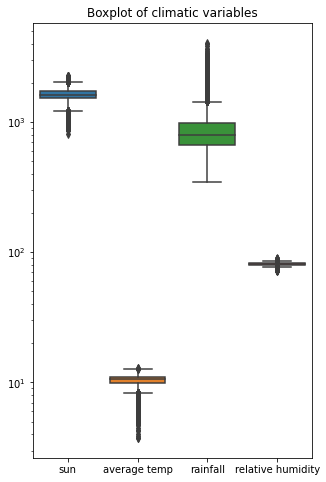

In [129]:
df1_climate = df.drop(columns=['Simpsons Index','SPECIES RICHNESS','TOTAL SITE INDEX','Site Number', 'YEAR', 'Easting','Northing','latitude','longitude'])
df1_climate.describe()
df2_clim = df.drop(columns=['Site Number', 'YEAR', 'Easting','Northing','latitude','longitude'])

fig,ax = plt.subplots(figsize=(5,8))
bxplot = sns.boxplot(data=df1_climate)
bxplot.set_yscale('log')
plt.title('Boxplot of climatic variables')

In [138]:
df2_clim.describe()

,SPECIES RICHNESS,TOTAL SITE INDEX,sun,average temp,rainfall,relative humidity,Simpsons Index
count,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000,24558.000000
mean,19.234425,1242.418682,1613.894576,10.396600,865.006929,81.345841,0.710798
std,9.719643,1444.173563,174.682971,0.968519,303.500379,1.865286,0.224897
min,1.000000,2.000000,806.658881,3.743084,346.315933,72.328381,0.000000
25%,12.000000,332.000000,1519.217458,9.918850,668.173773,80.315312,0.670328
50%,21.000000,839.000000,1616.506798,10.573544,801.808547,81.418960,0.792174
75%,27.000000,1639.000000,1722.647021,11.021346,976.247667,82.449404,0.851941
max,42.000000,38246.000000,2244.008016,12.839887,4071.312595,90.018887,1.000000


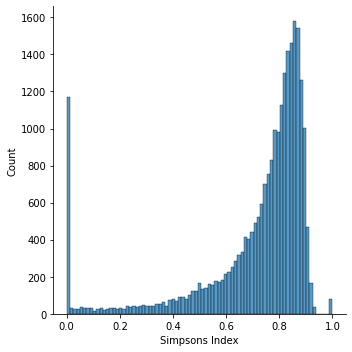

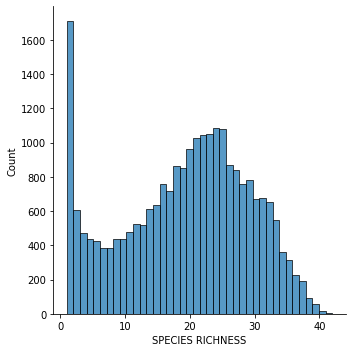

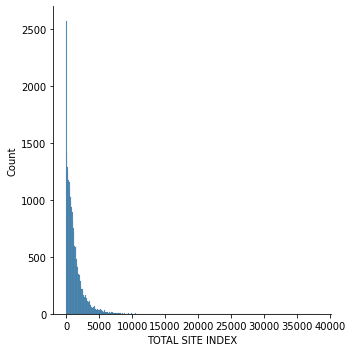

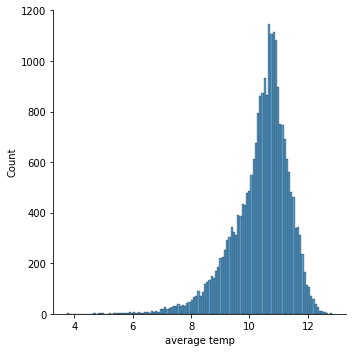

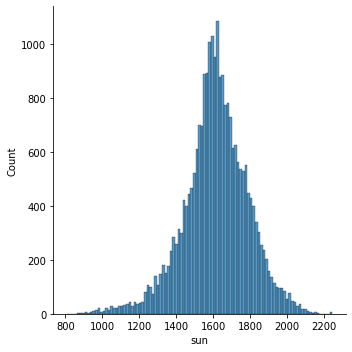

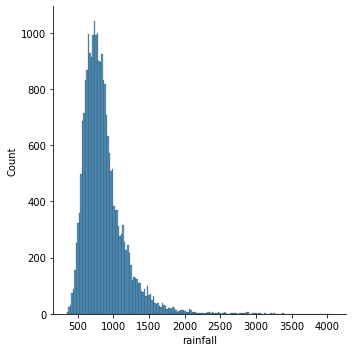

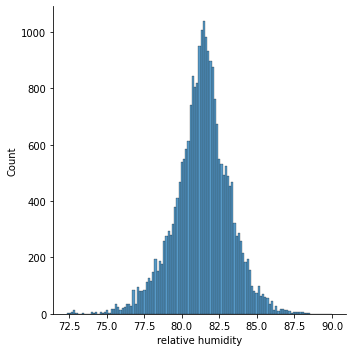

In [130]:
sns.displot(df['Simpsons Index'])
sns.displot(df['SPECIES RICHNESS'])
sns.displot(df['TOTAL SITE INDEX'])
sns.displot(df['average temp'])
sns.displot(df['sun'])
sns.displot(df['rainfall'])
sns.displot(df['relative humidity'])

Multiple Linear Regression, carried out on climatic variables (x) and species richness  (y):


In [131]:
x = df[['sun','average temp','rainfall','relative humidity']]
y= df[['SPECIES RICHNESS']]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3, random_state=44) #split into training and testing sets

<AxesSubplot:>

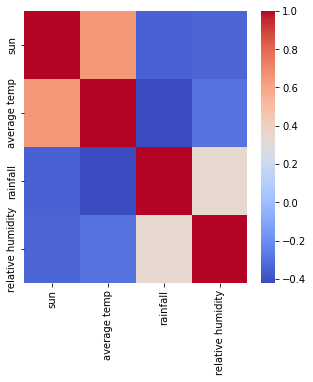

In [132]:
corr = df1_climate.corr()
plt.figure(figsize=(5,5))
sns.heatmap(corr, cmap='coolwarm')

In [133]:
x_train.drop(columns=['sun'],inplace=True)
x_test.drop(columns=['sun'],inplace=True)

In [134]:
#training multiple linear regression model 
model = LinearRegression()
model.fit(x_train, y_train)
print(model.coef_)
print(model.intercept_)

[[ 0.96703309 -0.00211092 -0.45044449]]
[47.625016]


In [135]:
preds_SR = model.predict(x_test)

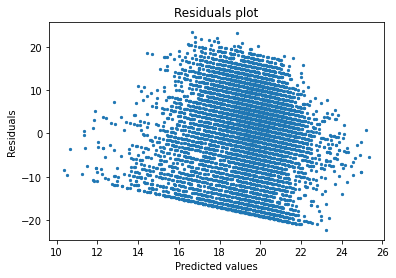

In [136]:
#plotting residuals
residuals = y_test-preds_SR
plt.scatter(preds_SR,residuals,5)
plt.ylabel('Residuals')
plt.xlabel('Predicted values')
plt.title('Residuals plot')
plt.show()

In [137]:
mse = metrics.mean_squared_error(y_test,preds_SR)
r2 = metrics.r2_score(y_test,preds_SR)
print(mse)
print(np.sqrt(mse))
print(r2)

91.9585298731896
9.589501023160151
0.039946953528546936


In [37]:
#Checking diversity
x = df[['average temp','rainfall','relative humidity']]
y= df[['Simpsons Index']]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3, random_state=44)
model1 = LinearRegression()
model1.fit(x_train, y_train)
print(model1.coef_)
print(model1.intercept_)
preds_Div = model1.predict(x_test)
mse = metrics.mean_squared_error(y_test,preds_Div)
r2 = metrics.r2_score(y_test,preds_Div)
print('mse: ' + str(mse))
print('rmse: ' + str(np.sqrt(mse)))
print('r2: ' + str(r2))

[[ 9.50157468e-03 -7.94726070e-05 -8.92072927e-03]]
[1.40639564]
mse: 0.04964239506285567
rmse: 0.22280573390928626
r2: 0.03478576404689471


Decision tree classifier:

0.6391638834523053
0.6245928338762216


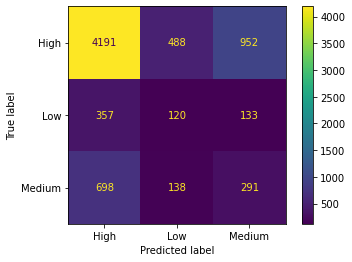

In [205]:
#multiclass classifcation decision tree classifier
x_c = df[['sun','average temp','rainfall','relative humidity']]
y_c = df[['Diversity']]
x_ctrain,x_ctest,y_ctrain,y_ctest = train_test_split(x_c,y_c,test_size=0.3,random_state=44)

dtree_model = tree.DecisionTreeClassifier(class_weight='balanced')
dtree_model.fit(x_ctrain,y_ctrain)
dtree_preds = dtree_model.predict(x_ctest)

cm = metrics.confusion_matrix(y_ctest,dtree_preds)
acc = metrics.accuracy_score(y_ctest, dtree_preds)

metrics.ConfusionMatrixDisplay.from_predictions(y_ctest,dtree_preds)
print(metrics.f1_score(y_ctest,dtree_preds, average='weighted'))
print(acc)

In [186]:
#hyperparameter tuning 
parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11],
           "min_samples_leaf":[1,3,5,7,9],
           "min_weight_fraction_leaf":[0,0.1,0.2,0.3,0.4],
           "max_features":[1,"log2","sqrt",None],
           "max_leaf_nodes":[None,10,30,50,70,90] }

In [213]:
custom_f1 = metrics.make_scorer(
    metrics.f1_score, greater_is_better=True, average="weighted", labels=["Medium", "Low"]
  )

In [216]:
#d tree classifier tunin
ctree_tuning = tree.DecisionTreeClassifier(class_weight='balanced')
c_tuning_model=GridSearchCV(ctree_tuning,param_grid=parameters,scoring=custom_f1,cv=3)

In [217]:
c_tuning_model.fit(x_ctrain,y_ctrain) 

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(class_weight='balanced'),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11],
                         'max_features': [1, 'log2', 'sqrt', None],
                         'max_leaf_nodes': [None, 10, 30, 50, 70, 90],
                         'min_samples_leaf': [1, 3, 5, 7, 9],
                         'min_weight_fraction_leaf': [0, 0.1, 0.2, 0.3, 0.4],
                         'splitter': ['best', 'random']},
             scoring=make_scorer(f1_score, average=weighted, labels=['Medium', 'Low']))

In [224]:
print(c_tuning_model.best_params_)
print(c_tuning_model.best_score_)

{'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 30, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}
0.23916131013041977


0.3310260586319218


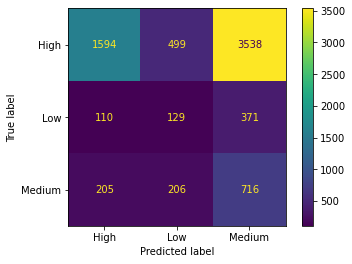

In [219]:
tuned_ctree = tree.DecisionTreeClassifier(class_weight='balanced',max_depth=3,max_features='sqrt',max_leaf_nodes=30,min_samples_leaf=9,min_weight_fraction_leaf=0.1,splitter='best')
tuned_ctree.fit(x_ctrain,y_ctrain) 
tuned_ctree_preds = tuned_ctree.predict(x_ctest)

acc = metrics.accuracy_score(y_ctest, tuned_ctree_preds)

metrics.ConfusionMatrixDisplay.from_predictions(y_ctest,tuned_ctree_preds)
print(acc)

KNN CLASSIFICATION - SCALED X VARIABLES:

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.682738313321154
0.748371335504886


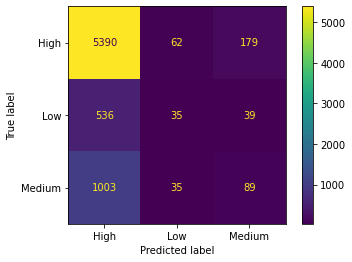

In [231]:
#scaled knn
scaler = StandardScaler()
df_scale = df.copy()
features = [['sun','average temp','rainfall','relative humidity']]
for feature in features:
    df_scale[feature] = scaler.fit_transform(df_scale[feature])

x_scaled  = df_scale[['sun','average temp','rainfall','relative humidity']]
y_s = df_scale[['Diversity']]

x_strain,x_stest,y_strain,y_stest = train_test_split(x_scaled,y_s,test_size=0.3,random_state=44)
knn_scaled_model = KNeighborsClassifier()
knn_scaled_model.fit(x_strain,y_strain)

knn_scaled_preds = knn_scaled_model.predict(x_stest)
acc_scaled = metrics.accuracy_score(y_stest,knn_scaled_preds)

metrics.ConfusionMatrixDisplay.from_predictions(y_stest,knn_scaled_preds)
print(metrics.f1_score(y_stest,knn_scaled_preds, average = 'weighted'))
print(acc_scaled)


In [232]:
metrics.f1_score(y_stest,knn_scaled_preds, average='weighted')

0.682738313321154

In [222]:
#knn  hyperparameter tuning
n_neighbors = [5,10,15,20,25,30]
leaf_size= list(range(1,25)) 
p=[1,2]

knn_hyperparameters = dict(n_neighbors=n_neighbors,leaf_size=leaf_size,p=p)
knn_tuned = KNeighborsClassifier()
knn_tuned_model = GridSearchCV(knn_tuned,knn_hyperparameters, scoring=custom_f1, cv=3)

In [223]:
knn_tuned_model.fit(x_strain,y_strain.values.ravel())
print('best leaf size:', knn_tuned_model.best_estimator_.get_params()['leaf_size'])
print('best p:', knn_tuned_model.best_estimator_.get_params()['p'])
print('best n_neighbors:', knn_tuned_model.best_estimator_.get_params()['n_neighbors'])


best leaf size: 1
best p: 2
best n_neighbors: 5


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.7476927252985885
0.6820484131213636


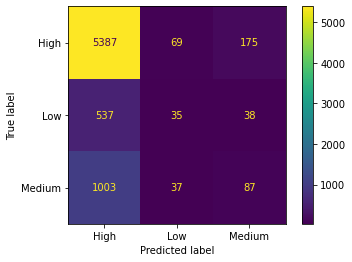

In [225]:
tuned_knn_model = KNeighborsClassifier(leaf_size=1,p=2,n_neighbors=5)
tuned_knn_model.fit(x_strain,y_strain)
tuned_knn_preds = tuned_knn_model.predict(x_stest)

acc_tuned_knn = metrics.accuracy_score(y_stest,tuned_knn_preds)

metrics.ConfusionMatrixDisplay.from_predictions(y_stest,tuned_knn_preds)
print(acc_tuned_knn)
print(metrics.f1_score(y_stest,tuned_knn_preds, average='weighted'))

Condensed Neareset Neighbor Undersamling:

In [50]:
undersample = under_sampling.CondensedNearestNeighbour()
x_under,y_under = undersample.fit_resample(x_strain,y_strain)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.6766766834716903
0.7593648208469055


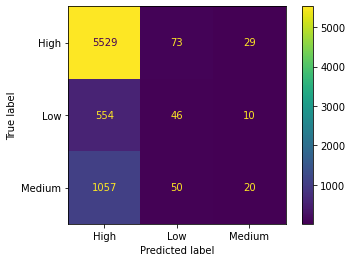

In [228]:
cnn_knn = KNeighborsClassifier(leaf_size=1,p=2,n_neighbors=30)
cnn_knn.fit(x_under,y_under)
cnn_knn_preds = cnn_knn.predict(x_stest)


acc_knn_cnn = metrics.accuracy_score(y_stest,cnn_knn_preds)
metrics.ConfusionMatrixDisplay.from_predictions(y_stest,cnn_knn_preds)
print(metrics.f1_score(y_stest,cnn_knn_preds, average = 'weighted'))

print(acc_knn_cnn)

In [52]:
rus_undersample = under_sampling.RandomUnderSampler(random_state=44,replacement=True)
x_rus,y_rus = undersample.fit_resample(x_strain,y_strain)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.6587949710559801
0.6980184581976113


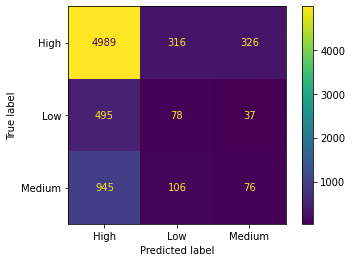

In [230]:
rus_knn = KNeighborsClassifier(leaf_size=1,p=2,n_neighbors=5)
rus_knn.fit(x_rus,y_rus)
rus_knn_preds = rus_knn.predict(x_stest)


acc_knn_rus = metrics.accuracy_score(y_stest,rus_knn_preds)
metrics.ConfusionMatrixDisplay.from_predictions(y_stest,rus_knn_preds)
print(metrics.f1_score(y_stest,rus_knn_preds, average = 'weighted'))
print(acc_knn_rus)